In [1]:
using JuMP, JuMPeR, Gurobi, Random, StatsBase, Distributions, LinearAlgebra, DataFrames, Plots, Distances

┌ Info: Recompiling stale cache file C:\Users\brian\.julia\compiled\v1.0\Plots\ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1190


# Process for generating synthetic data

Our supply and demand models time-dependent (can also be product dependent) are given by:
- Supply: $S_{t} =  (s_{t}+z_{t})p_{t} $ 
- Demand: $D_{t} = \alpha_{t} + \beta_{t}*p_{t}$

And the model which we are trying to maximize (profit) given that supply is greater than demand is given by:
$$\pi(p, z) = \sum_{t=1}^{T} D_{t}p_{t} - c_{t}D_{t} - \delta_{t}v_{t}$$ 

In the above we have
- Decision variables: $p_{t}$ (price at time $t$)
- Uncertain variables: $z_{t}$ (perturbation on the supply) 

The data is given by:
- $\alpha_{t}$: price-insensitive demand at time $t$
- $\beta_{t}$: slope of demand curve at time $t$ 
- $s_{t}$: slope of supply curve at time $t$ 
- $c_{t}$: cost (to the company) of a ride at time $t$, where the wage changes throughout the day
- $\delta_{t}$: the cost of unfulfilled drivers at time $t$ (to keep your drivers engaged)

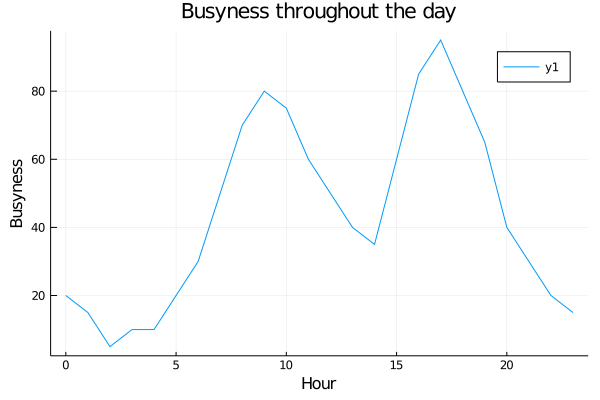

In [2]:
busyness_t = [20,15,5,10,10,20,30,50,70,80,75,60,50,40,35,60,85,95,80,65,40,30,20,15] # latent metric of busyness throughout the day from 0 to 100, starting at 00:00 (12 AM)
n_periods = length(busyness_t)
t = [i for i in range(0,stop =n_periods-1)]
plot(t,busyness_t,title="Busyness throughout the day", xlabel ="Hour",ylabel = "Busyness" )

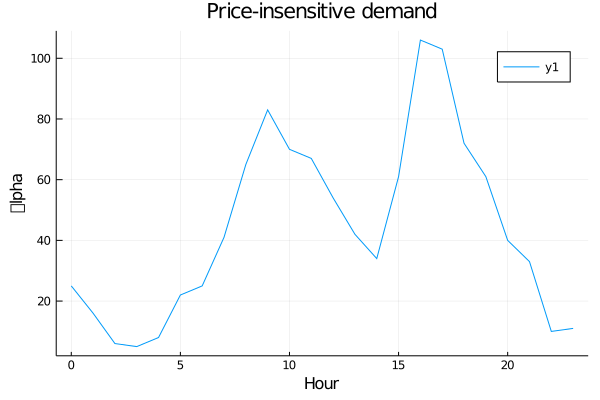

In [3]:
Random.seed!(MersenneTwister(15094)); # we simulate data for 24 hours (hourly timestep)
α = [rand(Poisson(x)) for x in busyness_t]
plot(t,α,title="Price-insensitive demand", xlabel ="Hour",ylabel = "\alpha" )

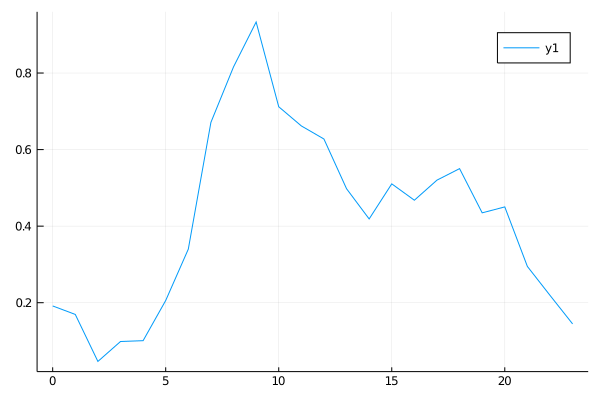

In [4]:

"""
Demand β ∈ [0,10]:
- Smaller β means that consumers are price insensitive (you change price, they don't change quantity of demand)
- Opposite for larger β
- Therefore expect slope to roughly follow busyness because at late hours, people will pay whatever price for a ride home
- In the early hours with lots of drivers, they can afford to take the subway/bus/other transportation
- The difference is that there is more sensitivity in the morning and less at night (if you drove to work, you drive back)
"""
β_t = [20,15,5,10,10,20,30,60,80,90,75,70,70,60,50,50,45,55,60,45,40,30,20,15]
β = [rand(Normal(x/100, x/1000)) for x in β_t] 
plot(t,β)

In [5]:
# plot actual demand throughout the day for different fixed price policies 
prices = [10,20,30,40,60,80,100]
D = zeros(n_periods,length(prices))
for i in range(1, stop = length(prices))
    p = prices[i]
    demand_t = [α[t]-β[t]*p for t in range(1,stop=n_periods)]
    demand_t = [if d>=0 d else 0 end for d in demand_t] # demand can never be negative
    D[:,i] = demand_t
end

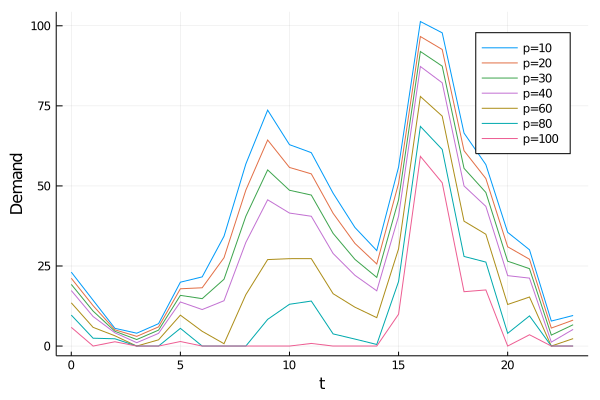

In [6]:
plot(t,D, label = ["p=10" "p=20" "p=30" "p=40" "p=60" "p=80" "p=100"],xlabel = "t", ylabel ="Demand")

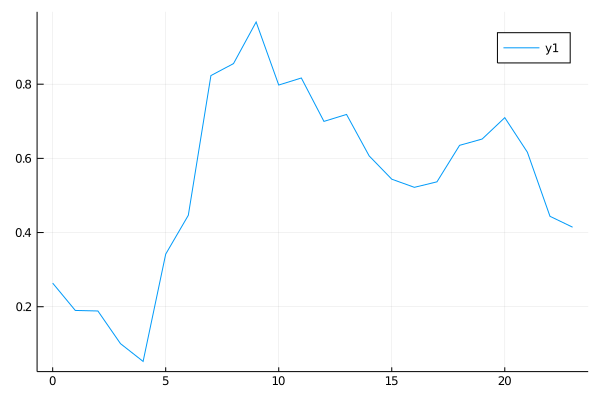

In [7]:
"""
Supply
- When simulating supply slope, we consider the number of active drivers at any time. 
- This is also generally correlated with business
- The only difference is that drivers are more active throughout the evening as well 
"""
s_t = [30,20,20,10,5,30,50,80,90,95,85,75,70,70,65,50,50,55,70,80,75,65,55,45]
s = [rand(Normal(x/100, x/1000)) for x in s_t] 
plot(t,s)


In [8]:
"""
Constants 
- c_t: wages for drivers as a percentage, we can assume that we pay a relatively stable proportion and a little bit more at peak hours  
- δ_t: driver keeping costs, generally higher in the day and lower at night
"""

c = [0.7,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.7,0.7,0.8,0.8,0.7,0.6,0.6,0.8,0.7,0.6,0.6,0.6,0.6,0.7,0.7];
δ = [ 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4];

# Solve the nominal problem

$$\pi(p, z) = \sum_{t=1}^{T} D_{t}p_{t} - c_{t}D_{t} + \delta_{t}v_{t}$$ 

In [9]:
m = Model(solver = GurobiSolver(OutputFlag=1))
@variable(m, p[1:n_periods] >= 0)
@variable(m, v[1:n_periods] >= 0)
@constraint(m, [t=1:n_periods], v[t] == s[t]*p[t] - (α[t]-β[t]*p[t])) # S > D at all periods
@constraint(m, [t=1:n_periods], v[t] >= 0)
@objective(m, Max, sum([(α[t]-β[t]*p[t])*(p[t]-c[t]) - δ[t]*v[t] for t=1:n_periods]));

In [10]:
solve(m)

Academic license - for non-commercial use only
Optimize a model with 48 rows, 48 columns and 72 nonzeros
Model has 24 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-01, 2e+00]
  Objective range  [2e+00, 1e+02]
  QObjective range [9e-02, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+02]
Presolve removed 48 rows and 48 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.00 seconds
Optimal objective 3.21155649e+04


:Optimal

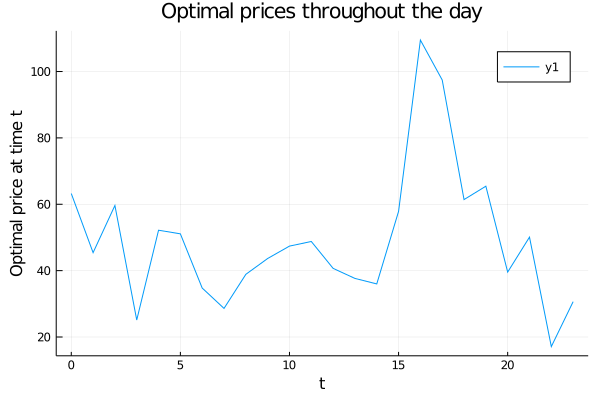

In [11]:
plot(t,getvalue.(p), xlabel = "t", ylabel="Optimal price at time t", title = "Optimal prices throughout the day")

# Simulate uncertainty set 

When simulating, note that there is a difference between defining the robustness SET and the respective probability DISTRIBUTION. The set is only defined by the boundaries (ellipsoidal, box, budget) while the distribution defines which points in that set are more likely to draw. 

For our purposes, I'll just be doing rejection sampling using a uniform/gaussian distribution, so all uncertainties are centered in the respective sets. 

In [39]:
# box
function generate_z_box(l,n,p)
    """
    Inputs:
    l: the shape of the box 
    n: number of samples
    p: dimension of samples
    
    Returns:
    n x p Matrix of samples 
    """
    return rand(Uniform(-l/2,l/2),n,p)
end

# ellipsoidal 
function generate_z_ellipse(ρ,n,p)
    """
    Inputs:
    ρ: size of l2 norm
    n: number of samples
    p: dimension of samples
    
    Returns:
    n x p Matrix of samples 
    """
    n_samples = 1
    v = zeros(n,p)
    while n_samples < n+1
        x = rand(Normal(0,1),p)
        if norm(x,2) <= ρ
            v[n_samples,:] = x
            n_samples += 1
        end
    end
    return v
end

# Budget
function generate_z_budget(ρ, γ, n, p)
    """
    At most γ (integer) elements are ρ away from their nominal values 
    """
    n_samples = 1
    v = zeros(n,p)
    while n_samples < n+1
        x = rand(Uniform(-γ,γ),p)
        if (norm(x,Inf) <= ρ) & (norm(x,1) <= γ)
            v[n_samples,:] = x
            n_samples += 1
        end
    end
    return v
end
    

generate_z_budget (generic function with 1 method)

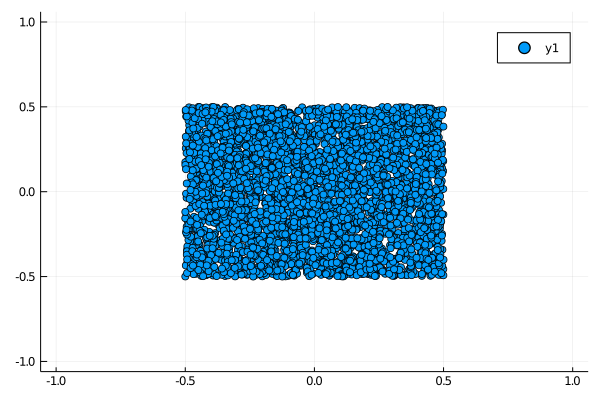

In [51]:
z = generate_z_box(1,4000,2)
scatter(z[:,1], z[:,2], xlim=[-1,1], ylim=[-1,1])

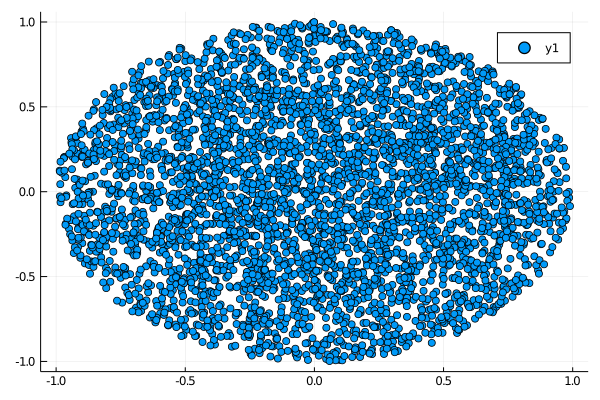

In [52]:
z = generate_z_ellipse(1,4000,2)
scatter(z[:,1], z[:,2], xlim=[-1,1], ylim=[-1,1])

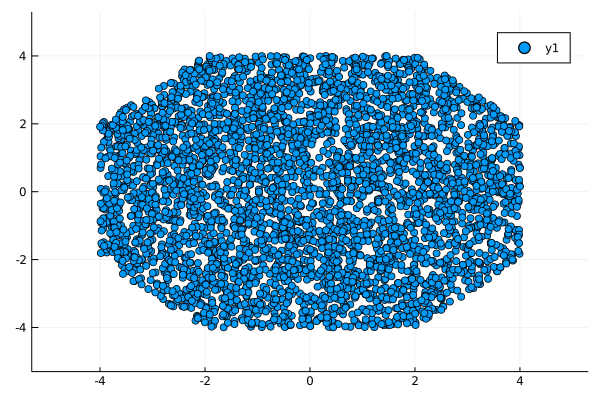

In [53]:
z = generate_z_budget(4,6,4000,2)
scatter(z[:,1], z[:,2], xlim=[-5,5], ylim=[-5,5])

# Next up: Set up robust problem and test profits between robust vs. nomial prices solved above